## Učitavanje podataka


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


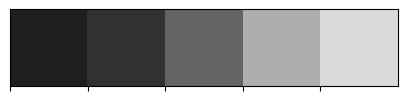

In [4]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
sns.palplot(colors_dark)

Imamo 4 klase

In [5]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

Uzela samo dio podataka(svaki 2.) radi lakšeg učitavanja

In [6]:
#nismo uzeli sve podatke, samo dio
import os
import cv2
import numpy as np
from tqdm import tqdm

X = []
y = []
image_size = 150

def load_images_from_folder(folder_path, label):
    images = []
    for idx, file_name in enumerate(os.listdir(folder_path)):
        if idx % 2 == 0:  # Uzimaj samo slike s parnim indeksom   ili uzimaj sve slike ovisno 1 ili 2 tu
            img = cv2.imread(os.path.join(folder_path, file_name))
            img = cv2.resize(img, (image_size, image_size))
            X.append(img)
            y.append(label)

# Promijenite putanju prema vašim podacima
base_path = '/content/drive/MyDrive/data'

for label in labels:
    training_folder_path = os.path.join(base_path, 'Training', label)
    load_images_from_folder(training_folder_path, label)

for label in labels:
    testing_folder_path = os.path.join(base_path, 'Testing', label)
    load_images_from_folder(testing_folder_path, label)

X = np.array(X)
y = np.array(y)


Prikažimo po 1 podatak iz svake klase

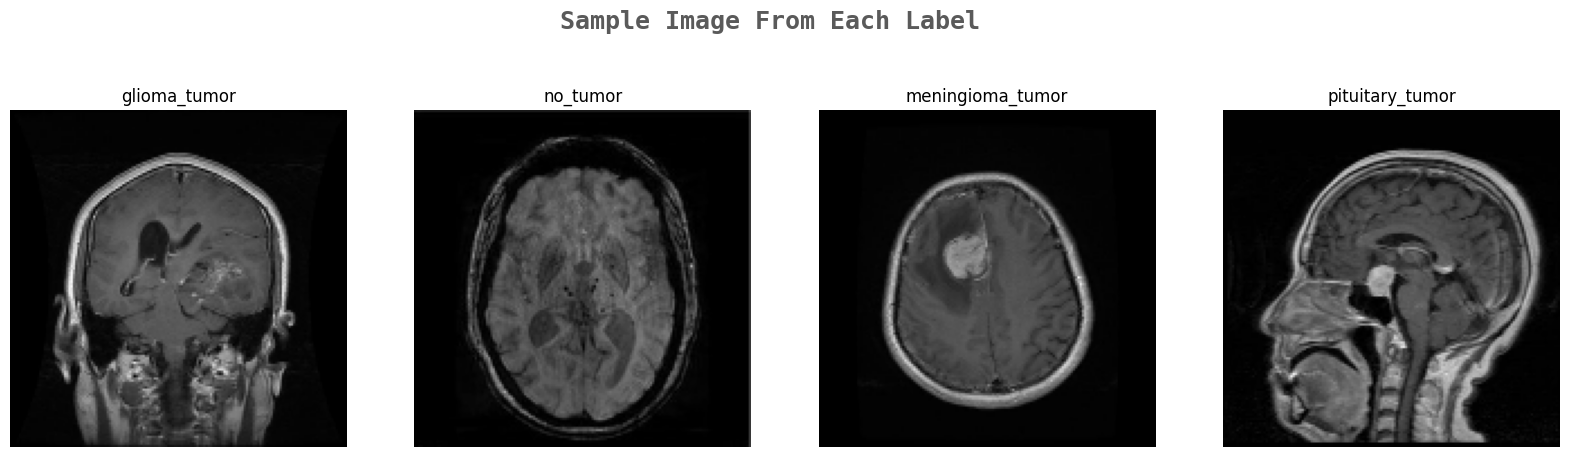

In [7]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y[j]==i:
            ax[k].imshow(X[j])
            ax[k].set_title(y[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

 Imamo 1634 slike, svaka dimenzija slike je 150x150 piksela, i svaka slika ima tri boje (RGB).

In [8]:
X.shape

(1634, 150, 150, 3)

In [9]:
X[0].shape

(150, 150, 3)

**SKALIRAMO PODATKE** jer:<br>
 1.Stabilnost algoritma optimizacije: Mnogi algoritmi optimizacije, posebice oni koji se temelje na gradijentnom spustu, brže konvergiraju kada su značajke skalirane na sličan raspon <br>
 2.Izbjegavanje numeričkih problema: Skaliranje pomaže u izbjegavanju numeričkih problema, poput overflow-a ili underflow-a <br>
 3.Regularizacija: Mnogi modeli, poput linearnih regresija i SVM-ova, uključuju regularizaciju. Skalirane značajke osiguravaju da svi koeficijenti doprinose jednako regularizaciji, čime se održava balans u pridonošenju svake značajke modelu <br>
 4.Jednostavnost interpretacije modela:kod klasifikacije, odlučujuće granice će biti bolje usklađene

In [10]:
# Ispis minimalne i maksimalne vrijednosti prije skaliranja
print("Min vrijednost prije skaliranja:", np.min(X))
print("Max vrijednost prije skaliranja:", np.max(X))

Min vrijednost prije skaliranja: 0
Max vrijednost prije skaliranja: 255


In [11]:
X=X/255.0

# Ispis minimalne i maksimalne vrednosti nakon skaliranja
print("Min vrijednost nakon skaliranja:", np.min(X))
print("Max vrijednost nakon skaliranja:", np.max(X))


Min vrijednost nakon skaliranja: 0.0
Max vrijednost nakon skaliranja: 1.0


**Dijelimo podatke na train i test**

In [12]:
from sklearn.model_selection import train_test_split

# Podijela podataka X i y na train i test skupove
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ispisivanje oblika rezultirajućih skupova
print("Oblik X_train:", X_train.shape)
print("Oblik X_test:", X_test.shape)
print("Oblik y_train:", y_train.shape)
print("Oblik y_test:", y_test.shape)


Oblik X_train: (1307, 150, 150, 3)
Oblik X_test: (327, 150, 150, 3)
Oblik y_train: (1307,)
Oblik y_test: (327,)


Provjera balansiranosti podataka:

<ipython-input-13-02420b80e280>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_train,
<ipython-input-13-02420b80e280>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_test,


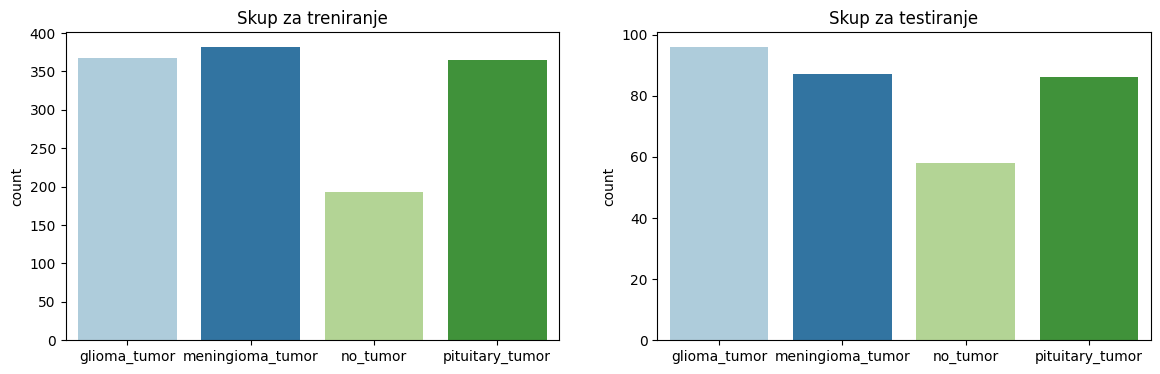

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def vizualiziraj_balans_klasa(y_train, y_test):
    train_sentiments, train_counts = np.unique(y_train, return_counts=True)
    test_sentiments, test_counts = np.unique(y_test, return_counts=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    ax = sns.countplot(x=y_train,
                       order=train_sentiments,
                       ax=ax1,
                       palette='Paired'
                       ).set(title='Skup za treniranje')

    ax = sns.countplot(x=y_test,
                       order=test_sentiments,
                       ax=ax2,
                       palette='Paired'
                       ).set(title='Skup za testiranje')

    plt.show()

# Poziv funkcije s oznakama klasa
vizualiziraj_balans_klasa(y_train, y_test)

**Ravnamo podatke tj preoblikujemo slike u 1-dimenzionalne vektore**

In [14]:
X_train_izravnan=X_train.reshape(X_train.shape[0],-1)

In [15]:
X_test_izravnan=X_test.reshape(X_test.shape[0],-1)

In [16]:
X_izravnan=X.reshape(X.shape[0],-1)

**Kodiranje zavisne varijable y pomoću CountFrequencyEncoder-a. Svaku kategoriju zamijenimo njenim brojem pojavljivanja unutar skupa podataka(kodiramo prema train skupu).**

In [18]:
!pip install feature_engine

In [19]:
y_train.shape

(1307,)

In [20]:
y_train.reshape(-1,1).shape

(1307, 1)

Očekuje 2-dim ulaz zato reshape(niz 1 dim nizova)

In [21]:
from feature_engine.encoding import CountFrequencyEncoder
encoder = CountFrequencyEncoder(encoding_method='count')
encoder.fit(y_train.reshape(-1,1))    #prema trening skupu napravljeno kodiranje
y_train_freq = encoder.transform(y_train.reshape(-1,1)).values.ravel() #da ne bi bio df .values + ravel da ne bi bio niz 1-dim nizova vec samo niz
y_test_freq = encoder.transform(y_test.reshape(-1,1)).values.ravel()

Sada su nam klase označene ovako:

In [22]:
np.unique(y_train_freq)

array([193, 365, 367, 382])

**Kodiranje zavisne varijable y pomoću OneHotEncodera**

In [23]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Pretvorba 1D niza u 2D niz s jednim stupcem
y_train_2d = y_train.reshape(-1, 1)
y_test_2d = y_test.reshape(-1, 1)

# Inicijalizacija OneHotEncoder-a
encoder = OneHotEncoder()

# Fit i transformacija za trening skup
y_train_onehot = encoder.fit_transform(y_train_2d).toarray()

# Transformacija za test skup
y_test_onehot = encoder.transform(y_test_2d).toarray()



Sada su nam klase označene ovako:

In [24]:
unique_rows = np.unique(y_train_onehot, axis=0)
unique_rows

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

**Numeričko kodiranje**

In [121]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_num = label_encoder.fit_transform(y_train)
y_test_num = label_encoder.transform(y_test)


Sada su nam klase označene ovako:

In [122]:
np.unique(y_train_num)

array([0, 1, 2, 3])

Sa učitanim podacima ćemo poslije raditi

##SVM

SVM je algoritam koji se koristi za razdvajanje dviju klasa (binarna klasifikacija) ili više klasa (višeklasna klasifikacija) stvaranjem hiperplohe u prostoru značajki. Hiperploha ima zadatak maksimizirati razmak između različitih klasa. Sloj potpornih vektora odnosi se na instance (primjere) podataka koje leže na granici razdvajanja ili su blizu nje. Ovi "potporni vektori" igraju ključnu ulogu u definiranju položaja i orijentacije hiperplohe.



## SVM GridSearch nad PCA podacima



Ekstrakcija značajki tj transformacija originalnih značajki u novi skup značajki<br> Transformiramo originalni skup podataka u novi skup varijabli, tzv. glavnih komponenata, smjerova najveće varijacije u prostoru značajki

Bitno je da koristimo skalirane podatke jer je PCA osjetljiv na raspon vrijednosti varijabli

Šaljemo n_components=0.95 pa će se  odabrat takav broj komponenti da udio objašnjene varijence s tim brojem komponenti bude veći od postotka specificiranog s n_components.

In [28]:
X_izravnan.shape

(1634, 67500)

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_izravnan)
print("Shape:", X_pca.shape)
print("Num components:", pca.n_components)
print("Componetns shape:", pca.components_.shape)
print(f"Explained variance: {pca.explained_variance_ratio_.sum()*100:.2f}%")

Shape: (1634, 607)
Num components: 0.95
Componetns shape: (607, 67500)
Explained variance: 95.01%


Br komponenti se smanjio sa 67500 na 607

In [29]:
from sklearn.model_selection import train_test_split

# Podijela podataka X i y na train i test skupove
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [30]:
#ocekuje 2-dim ulaz zato reshape(niz 1 dim nizova)
from feature_engine.encoding import CountFrequencyEncoder
encoder = CountFrequencyEncoder(encoding_method='count')
encoder.fit(y_train_pca.reshape(-1,1))    #prema trening skupu napravljeno kodiranje
y_train_freq_pca = encoder.transform(y_train_pca.reshape(-1,1)).values.ravel() #da ne bi bio df .values + ravel da ne bi bio niz 1-dim nizova vec samo niz
y_test_freq_pca = encoder.transform(y_test_pca.reshape(-1,1)).values.ravel()

Grid Search je tehnika optimizacije hiperparametara

Sporo unatoc PCA pa sam zakomentirala model.fit:

In [33]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# Defining the parameters grid for GridSearchCV
param_grid={'C':[0.1,1,10,100],
            'gamma':[0.0001,0.001,0.1,1],
            'kernel':['rbf','poly']}

# Creating a support vector classifier
svc=svm.SVC(probability=True)

# Creating a model using GridSearchCV with the parameters grid
model=GridSearchCV(svc,param_grid)


# Training the model using the training data
#model.fit(X_train_pca,y_train_freq)     #SPORO unatoc PCA

##SVM

In [38]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Inicijalizacija modela
svm_model = SVC(random_state=42)

# Treniranje modela
svm_model.fit(X_train_izravnan, y_train_freq)

# Predviđanja na skupu za testiranje
y_pred = svm_model.predict(X_test_izravnan)

# Evaluacija modela
accuracy = accuracy_score(y_test_freq, y_pred)

# Ispis tačnosti kao postotka
print(f"Točnost modela: {accuracy*100:.2f}%")


Točnost modela: 76.45%


In [39]:
support_vectors_per_class = svm_model.n_support_

# Ispis broja potpornih vektora po klasama
for class_label, support_count in zip(svm_model.classes_, support_vectors_per_class):
    print(f"Broj potpornih vektora za klasu {class_label}: {support_count}")

Broj potpornih vektora za klasu 193: 180
Broj potpornih vektora za klasu 365: 259
Broj potpornih vektora za klasu 367: 300
Broj potpornih vektora za klasu 382: 363


In [40]:
# Dobivanje svih potpornih vektora
all_support_vectors = svm_model.support_vectors_

# Ispis potpornih vektora
print("Svi potporni vektori:")
print(all_support_vectors)

Svi potporni vektori:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.03921569 0.03921569 0.03921569 ... 0.0627451  0.0627451  0.0627451 ]
 [0.0627451  0.0627451  0.0627451  ... 0.0627451  0.0627451  0.0627451 ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


##SVM OneVsRestClassifier nad PCA podacima

In [41]:
from sklearn.multiclass import OneVsRestClassifier
# Define SVM parameters
svm_params = {
    'C': 1.0,
    'gamma': 'scale',  # You can adjust this based on your data
    'kernel': 'rbf'    # You can choose 'poly' or other kernels based on your needs
}

# Create a support vector classifier
svc = SVC(**svm_params, probability=True)

# Wrap the classifier in OneVsRestClassifier
model = OneVsRestClassifier(svc)

# Train the model
model.fit(X_train_pca, y_train_freq)

# Predictions
y_pred = model.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test_freq, y_pred)

print(f"Točnost modela: {accuracy*100:.2f}%")

Točnost modela: 77.98%


##Logistička regresija



##Multinomialna logistička regresija (generalizacija binarne na više od 2 klase)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

model = LogisticRegression(multi_class="multinomial")

# Train the model
model.fit(X_train_izravnan, y_train_freq)

# Make predictions
y_pred = model.predict(X_test_izravnan)

# Evaluacija performansi modela
accuracy = accuracy_score(y_test_freq, y_pred)

# Ispis rezultata
print('Točnost za {} iteracija: {}%'.format(100, np.round(accuracy, 4) * 100))

Točnost za 100 iteracija: 71.56%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##One vs rest logistička regresija (transformira višeklasni problem u više binarnih problema)

In [44]:
model = LogisticRegression(multi_class="ovr")

# Train the model
model.fit(X_train_izravnan, y_train_freq)

# Make predictions
y_pred = model.predict(X_test_izravnan)

# Evaluacija performansi modela
accuracy = accuracy_score(y_test_freq, y_pred)

# Ispis rezultata
print('Točnost za {} iteracija: {}%'.format(100, np.round(accuracy, 4) * 100))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Točnost za 100 iteracija: 72.78%


##Naivni Bayes

Familija algoritama koje koristimo za klasifikacija , osnovna "naivna" pp je da su značajke/varijable nezavisne

Značajke su numeričke/kontinuirane i pretpostavljamo da su podaci normalno distribuirani

In [45]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Inicijalizacija modela Gaussian Naive Bayes
gnb = GaussianNB()

# Treniranje modela na skupu za treniranje
gnb.fit(X_train_izravnan, y_train_freq)

# Predviđanje na skupu za testiranje
y_pred = gnb.predict(X_test_izravnan)

# Evaluacija performansi modela
accuracy = accuracy_score(y_test_freq, y_pred)
print("Točnost modela:", accuracy)

# Ispisivanje izvještaja o klasifikaciji
print("Izvještaj o klasifikaciji:\n", classification_report(y_test_freq, y_pred))


Točnost modela: 0.5535168195718655
Izvještaj o klasifikaciji:
               precision    recall  f1-score   support

         193       0.59      0.55      0.57        58
         365       0.75      0.64      0.69        86
         367       0.47      0.90      0.62        96
         382       0.47      0.09      0.15        87

    accuracy                           0.55       327
   macro avg       0.57      0.54      0.51       327
weighted avg       0.57      0.55      0.51       327



Zašto je točnost mala?

In [46]:
from scipy.stats import anderson, shapiro, kstest

# Odaberite klasu i značajku za koje želite provesti testove normalnosti
klasa = 'glioma_tumor'
značajka = 0  # Postavite na indeks željene značajke

# Izdvojite vrijednosti značajke za odabranu klasu
feature_values = X[y == klasa][:, značajka].reshape(-1)

# Kolmogorov-Smirnov test za normalnost
stat, p_value = kstest(feature_values, 'norm')
print(f"Kolmogorov-Smirnov test za {klasa}, značajka {značajka + 1}: {stat}, p-vrijednost: {p_value}")


Kolmogorov-Smirnov test za glioma_tumor, značajka 1: 0.5, p-vrijednost: 0.0


Kolmogorov-Smirnov test za glioma_tumor, značajka 1: 0.5, p-vrijednost: 0.0

Kolmogorov-Smirnov test također provjerava normalnost podataka. Statistička vrijednost testa je 0.5, a p-vrijednost je 0.0. Kao i kod drugih testova, niska p-vrijednost sugerira da podaci nisu normalno distribuirani.

**Zaključak:**

Iako Naivni Bayes može biti koristan za klasifikaciju u nekim slučajevima, obično se koristi za obradu tekstualnih podataka i podataka s diskretnim značajkama. Kada su u pitanju slike, posebno one u kojima su susjedni pikseli često povezani, modeli kao što su konvolucijske neuronske mreže (CNN) često daju bolje rezultate jer mogu naučiti prostorne značajke i odnose između piksela




Naivni Bayes modeli, uključujući Gaussian Naive Bayes , često nisu najbolji izbor za klasifikaciju slika iz nekoliko razloga:

Pretpostavka o nezavisnosti značajki: Naivni Bayes modeli pretpostavljaju nezavisnost značajki, što može biti neprikladno za slike. Pixeli u slici često imaju kompleksne međusobne ovisnosti, posebno kada se radi o slikama visoke rezolucije

Problemi s dimenzionalnošću: Slike obično imaju veliki broj dimenzija (svaki piksel predstavlja jednu dimenziju). Kada imamo puno dimenzija, NB modeli mogu imati problema s previše parametara koje treba procijeniti, a to može dovesti do visokih zahtjeva za memorijom i vremenom izvođenja

Ograničenje na linearne ovisnosti: GNB pretpostavlja normalnu distribuciju značajki, što može ograničiti sposobnost modela da se nosi s kompleksnim ne-linearnim odnosima u podacima, što često vidimo u slikama



________________________________________________________________________________

##Stabla odluke

Ne zahtijevaju skaliranje podataka, ali smo ih već skalirali

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train_izravnan, y_train_freq)

DecisionTreeClassifier()

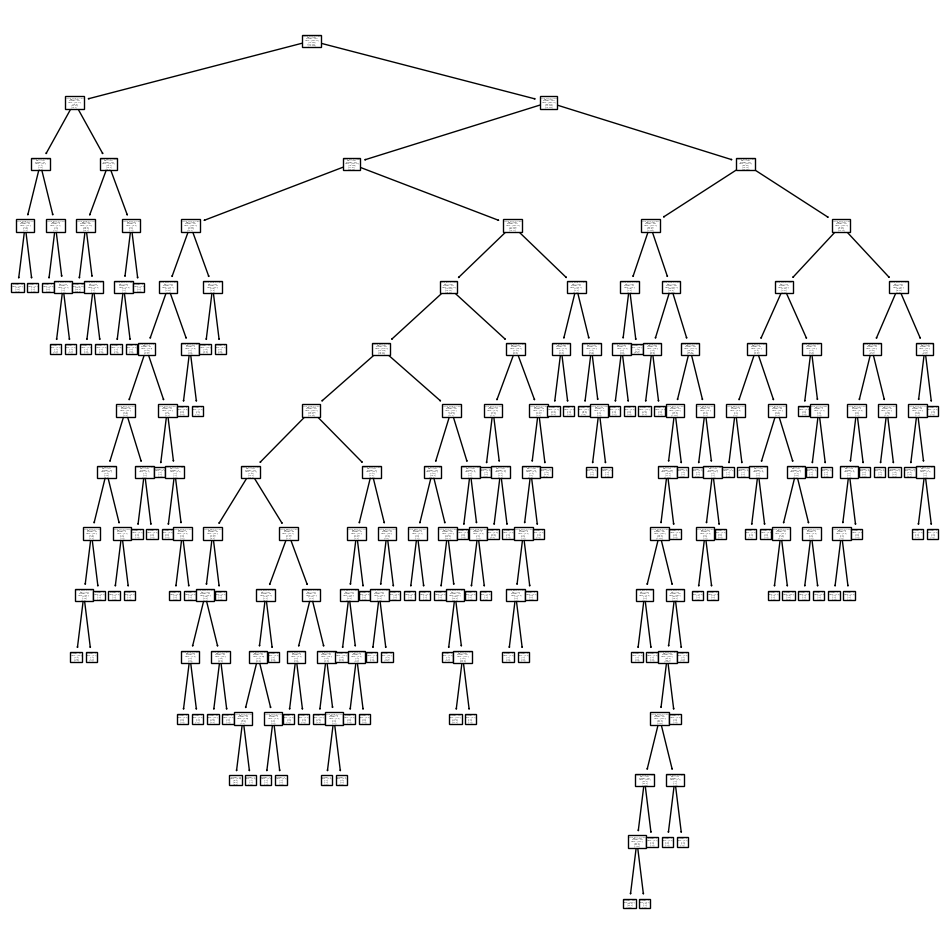

In [49]:
# Generiranje imena značajki
num_features = 150 * 150 * 3
feature_names = [f"feature_{i+1}" for i in range(num_features)]

# Postavljanje veličine figure
plt.figure(figsize=(12, 12))

# Crtanje stabla odluke
tree.plot_tree(clf, feature_names=feature_names, class_names=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

# Prikazivanje grafa
plt.show()


In [50]:
from sklearn.tree import export_graphviz
import graphviz

# Generiranje imena značajki
num_features = 150 * 150 * 3
feature_names = [f"feature_{i+1}" for i in range(num_features)]

# Export grafa odluke u DOT format
dot_data = export_graphviz(clf,
                           out_file=None,
                           feature_names=feature_names,
                           class_names=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
                           filled=True,
                           rounded=True,
                           special_characters=True)

# Konvertiranje DOT formata u grafički prikaz
graph = graphviz.Source(dot_data)
graph.render("decision_tree_plot", format="png")  # Ovo će stvoriti PNG datoteku s imenom "decision_tree_plot.png"
graph.view("decision_tree_plot")  # Ovo će prikazati grafički prikaz u pregledniku


'decision_tree_plot.pdf'

my drive search decision_tree_plot.png tu se pojavi slika stabla

In [63]:
from sklearn import metrics
y_pred = clf.predict(X_train_izravnan)
acc = metrics.accuracy_score(y_train_freq, y_pred)
print(f"Točnost na skupu za treniranje: {acc*100:.2f}%")

Točnost na skupu za treniranje: 100.00%


In [64]:
y_pred = clf.predict(X_test_izravnan)
acc = metrics.accuracy_score(y_test_freq, y_pred)
print(f"Točnost na skupu za testiranje: {acc*100:.2f}%")

Točnost na skupu za testiranje: 75.23%


**Komentar:** <br>
 Kada sam koristila y kodiran one-hot točnost je bila za 1% manja

**Komentar:**

Stabla odluke mogu se koristiti za klasifikaciju slika, ali nisu uvijek najbolji izbor, pogotovo ako je riječ o većim skupovima podataka s visokom rezolucijom. Stabla odluke imaju određene prednosti i nedostatke u kontekstu klasifikacije slika:

Prednosti:

Jednostavna interpretacija: Stabla odluke omogućuju lako tumačenje donesenih odluka, jer možete pratiti put koji je model slijedio kako bi donio određenu klasifikaciju.

Otpornost na neke oblike preprocesiranja: Stabla odluke mogu raditi dobro s podacima koji nisu potpuno obrađeni ili normalizirani, što ih čini robusnim u određenim situacijama.

Nedostaci:

Nedostatak sposobnosti učenja složenih značajki: Stabla odluke ne uvode automatski hijerarhiju u podacima kao što to čine konvolucijske neuronske mreže (CNN). To znači da mogu imati problema s prepoznavanjem složenih značajki u slikama.

Nedostatak robusnosti na varijacije u podacima: Stabla odluke mogu biti osjetljiva na male promjene u podacima, što ih čini manje robusnima u odnosu na druge modele, posebno kada su podaci šumoviti ili kada postoji velika varijacija u slikama.

Ograničenja učenja iz velikih skupova podataka: Za velike skupove podataka s visokom dimenzionalnošću, stabla odluke mogu postati prekomjerno složena i teška za treniranje, što dovodi do problema s prenaučenošću.

##Slučajne šume

In [65]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_izravnan, y_train_freq)
y_pred_rf = clf_rf.predict(X_test_izravnan)

acc_test = metrics.accuracy_score(y_test_freq, y_pred_rf)
print(f"Točnost na skupu za testiranje: {acc_test*100:.2f}%")

Točnost na skupu za testiranje: 81.35%


**Komentar:** <br>  poboljšala se točnost u odnosu na stablo

##Podrezivanje stabla (max dubina 3)

In [67]:
pruned_model = DecisionTreeClassifier(max_depth=3, random_state=42)
pruned_model.fit(X_train_izravnan, y_train_freq)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [69]:
pruned_train_accuracy = pruned_model.score(X_train_izravnan, y_train_freq)
print(f'Pruned Training Accuracy: {pruned_train_accuracy}') ##koristimo tocnost kao metriku

Pruned Training Accuracy: 0.6817138485080336


In [70]:
pruned_test_accuracy = pruned_model.score(X_test_izravnan, y_test_freq)
print(f'Pruned Test Accuracy: {pruned_test_accuracy}')

Pruned Test Accuracy: 0.6391437308868502


Loše rezano stablo, točnost se smanjila

Mogli bi Koristeći GridSearch metodu, ispitajte koja bi bila "najbolja" kombinacija hiperparametara max_depth and min_samples_leaf (ali dugo traje)

_________________________________________________________

##PCA I TSNE VIZUALIZACIJA NA VEĆ IZRAVNANIM PODACIMA

In [71]:
X_izravnan.shape

(1634, 67500)

67500-dimenzionalne podatke transformiramo u 2-dimenzionalne podatke

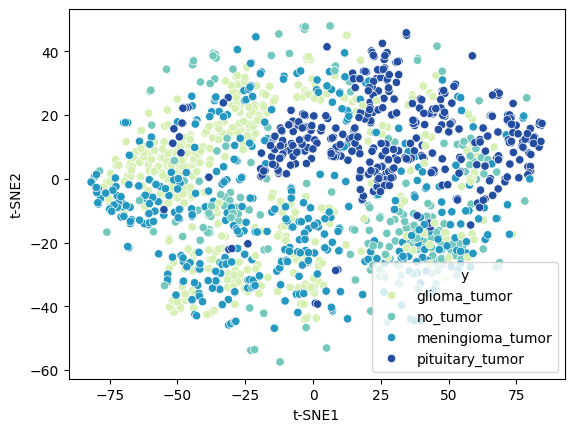

In [73]:
#TSNE je nelinearna tehnika
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Primjena TSNE
tsne = TSNE(n_components=2, init='random', random_state=0)
X_tsne_2dim = tsne.fit_transform(X_izravnan)

# Podatke spremamo u DataFrame
X_tsne_2dim = pd.DataFrame(X_tsne_2dim, columns=["t-SNE1", "t-SNE2"])
X_tsne_2dim["y"] = y  # Pretpostavljamo da je y vaša ciljna varijabla

# Vizualizacija scatter plot-a
sns.scatterplot(x="t-SNE1", y="t-SNE2", data=X_tsne_2dim, hue="y", palette="YlGnBu")
plt.show()


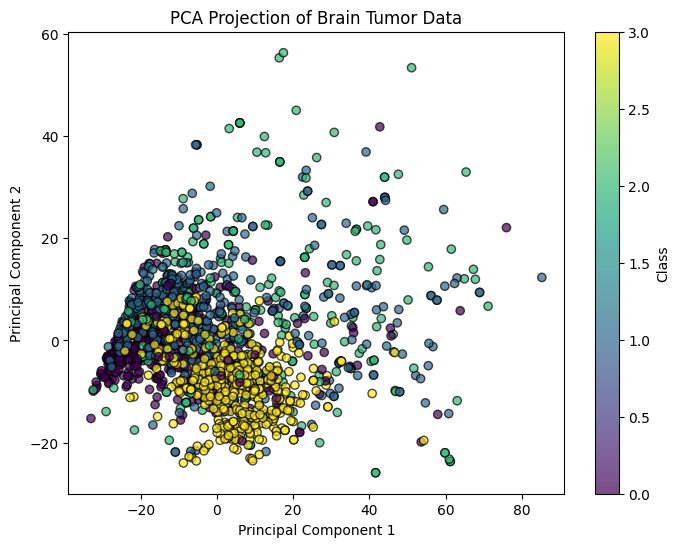

In [74]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Inicijalizacija LabelEncoder-a
le = LabelEncoder()

# Pretvaranje klasa u numeričke oznake
y_encoded = le.fit_transform(y)

# Inicijalizacija PCA modela s brojem komponenti koje želite zadržati
num_components = 2  # Prilagodite ovisno o potrebama
pca = PCA(n_components=num_components)

# Primjena PCA na podatke
X_pca = pca.fit_transform(X_izravnan)

# Prikazivanje rezultata
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of Brain Tumor Data')
plt.colorbar(label='Class')
plt.show()



___________________________________________________________________

##CNN(Konvolucijske neuronske mreže)

Ovaj model za razliku od prethodnik ne očekuje izravnane podatke tj radimo sa originalnim skaliranim podacima

##Model 1

Kada y kodiramo sa onehot (zato stavljamo CategoricalCrossentropy kao funkciju gubitka) :

In [125]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Pretvaranje imena klasa u one-hot kodirane vektore            ako u y imena klasa ond pretv u one hot vektore i loss function CategoricalCrossentropy
#ako u y numericki ozn klase 0,1,2,3 onda ostavljas posatke takvima i               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),


# Prilagodba modela za 4 klase
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')  # Broj izlaza postavljen na 4 za 4 klase
])

# Kompilacija modela s CategoricalCrossentropy
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Pregledavanje arhitekture modela
model.summary()

# Treniranje modela
povijest=model.fit(X_train, y_train_onehot, epochs=10, validation_data=(X_test, y_test_onehot))

# Evaluacija modela na testnom skupu
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot,verbose=2)

print(f"\nTočnost na testnom skupu: {test_accuracy * 100:.2f}%")



Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_61 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_62 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_62 (MaxPooli  (None, 17, 17, 128)     

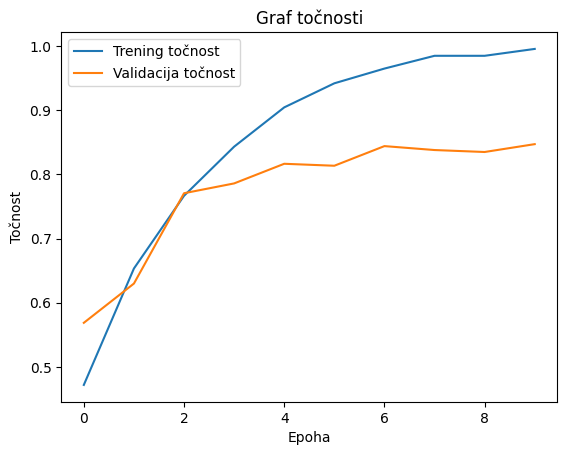

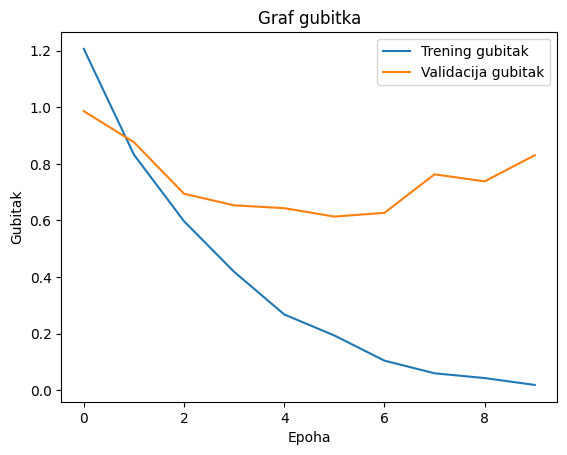

In [126]:
import matplotlib.pyplot as plt

# Prikazivanje grafa tačnosti
plt.plot(povijest.history['accuracy'], label='Trening točnost')
plt.plot(povijest.history['val_accuracy'], label='Validacija točnost')
plt.title('Graf točnosti')
plt.xlabel('Epoha')
plt.ylabel('Točnost')
plt.legend()
plt.show()

# Prikazivanje grafa gubitka
plt.plot(povijest.history['loss'], label='Trening gubitak')
plt.plot(povijest.history['val_loss'], label='Validacija gubitak')
plt.title('Graf gubitka')
plt.xlabel('Epoha')
plt.ylabel('Gubitak')
plt.legend()
plt.show()


Važno je pratiti performanse modela na validacijskom skupu kako bi izbjegao prenaučenost/overfitting tj točnost na trening skupu značajno veća od točnosti na validacijskom skupu

##Model 2

Kada y kodiramo sa labelencoderom(numerički) (zato stavljamo sparse_categorical_crossentropy kao funkciju gubitka) :

In [127]:
model2 = tf.keras.models.Sequential()

model2.add(tf.keras.layers.Conv2D(32, kernel_size=(5, 5), input_shape=(150, 150, 3), activation='relu'))
model2.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model2.add(tf.keras.layers.Conv2D(64, kernel_size=(5, 5), activation='relu'))
model2.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model2.add(tf.keras.layers.Flatten())

model2.add(tf.keras.layers.Dense(16, activation='relu'))
model2.add(tf.keras.layers.Dense(4, activation='softmax'))

model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

povijest2 = model2.fit(X_train, y_train_num, epochs=15, batch_size=64, validation_split=0.2)

_, test_acc = model2.evaluate(X_test, y_test_num, verbose=0)
print("Točnost na skupu za testiranje: {:.2f}%".format(test_acc * 100))


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d_63 (MaxPooli  (None, 73, 73, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_64 (Conv2D)          (None, 69, 69, 64)        51264     
                                                                 
 max_pooling2d_64 (MaxPooli  (None, 34, 34, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_24 (Flatten)        (None, 73984)             0         
                                                                 
 dense_48 (Dense)            (None, 16)              

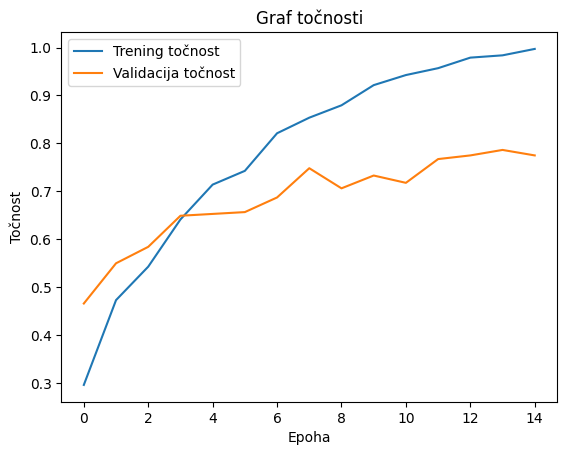

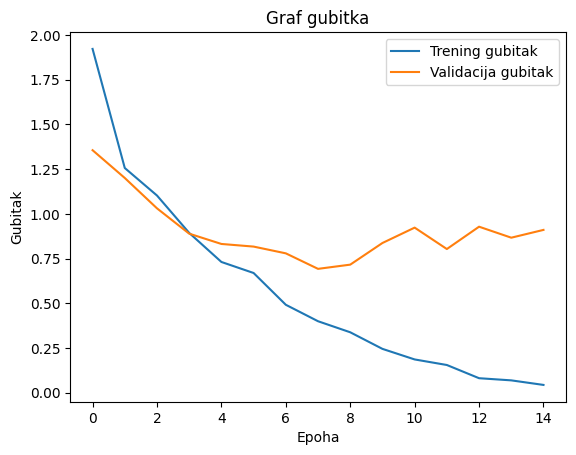

In [128]:
import matplotlib.pyplot as plt

# Prikazivanje grafa tačnosti
plt.plot(povijest2.history['accuracy'], label='Trening točnost')
plt.plot(povijest2.history['val_accuracy'], label='Validacija točnost')
plt.title('Graf točnosti')
plt.xlabel('Epoha')
plt.ylabel('Točnost')
plt.legend()
plt.show()

# Prikazivanje grafa gubitka
plt.plot(povijest2.history['loss'], label='Trening gubitak')
plt.plot(povijest2.history['val_loss'], label='Validacija gubitak')
plt.title('Graf gubitka')
plt.xlabel('Epoha')
plt.ylabel('Gubitak')
plt.legend()
plt.show()


##Točnost na skupu za testiranje je veća za Model 1 nego Model 2 pa ćemo raditi sa njim

##Vjerojatnost pripadanja određenoj klasi

In [136]:
import numpy as np

# Make predictions on test set
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate predictions
accuracy = np.mean(predicted_labels == y_test_num) ## If you started with one-hot encoding, convert it back to class labels,zato ovde y_test_num

print(f"\nTočnost predikcija na testnom skupu: {accuracy * 100:.2f}%")


11/11 [==============================] - 0s 9ms/step

Točnost predikcija na testnom skupu: 84.71%


In [134]:
predictions

array([[4.2036663e-07, 6.9224961e-07, 1.5307643e-05, 9.9998367e-01],
       [2.9775968e-08, 7.2876725e-07, 3.3876640e-07, 9.9999893e-01],
       [7.3920667e-01, 2.3820513e-01, 2.2587487e-02, 7.0993411e-07],
       ...,
       [9.9893588e-01, 1.0641012e-03, 2.3806014e-11, 9.1948660e-10],
       [2.3676289e-02, 9.7632015e-01, 3.5174528e-06, 4.7391307e-08],
       [3.8425704e-05, 2.4700619e-05, 8.6144923e-05, 9.9985063e-01]],
      dtype=float32)

In [139]:
predictions.shape

(327, 4)

In [138]:
predicted_labels

array([3, 3, 0, 2, 1, 3, 2, 1, 3, 0, 2, 1, 1, 3, 3, 2, 1, 2, 2, 2, 0, 0,
       2, 1, 1, 0, 3, 2, 1, 1, 2, 0, 3, 2, 0, 0, 2, 0, 0, 1, 1, 1, 2, 0,
       2, 3, 2, 2, 0, 0, 0, 0, 3, 0, 1, 1, 0, 2, 0, 1, 1, 0, 2, 0, 0, 1,
       2, 0, 3, 2, 0, 0, 1, 1, 0, 1, 3, 3, 0, 2, 0, 1, 1, 3, 0, 3, 3, 1,
       3, 0, 1, 3, 0, 1, 0, 0, 3, 1, 3, 3, 3, 2, 3, 1, 1, 3, 1, 0, 1, 3,
       2, 2, 3, 0, 3, 2, 2, 3, 3, 2, 1, 0, 0, 3, 2, 3, 3, 3, 1, 2, 3, 1,
       1, 0, 0, 1, 1, 2, 1, 1, 3, 0, 0, 2, 1, 2, 2, 3, 0, 2, 0, 0, 3, 1,
       3, 3, 0, 3, 0, 3, 0, 1, 0, 2, 3, 0, 3, 3, 3, 3, 0, 2, 1, 0, 0, 1,
       3, 1, 1, 3, 0, 2, 0, 1, 3, 1, 0, 3, 3, 1, 2, 3, 0, 3, 0, 3, 1, 0,
       1, 1, 1, 2, 3, 0, 1, 2, 3, 1, 2, 1, 1, 0, 2, 1, 1, 0, 0, 3, 0, 3,
       3, 0, 0, 2, 3, 1, 1, 3, 2, 1, 1, 1, 0, 3, 0, 3, 3, 1, 0, 3, 3, 1,
       3, 0, 0, 2, 3, 0, 1, 2, 2, 1, 0, 0, 1, 1, 0, 1, 3, 3, 0, 1, 0, 1,
       0, 1, 2, 3, 1, 1, 3, 3, 3, 0, 1, 0, 0, 0, 3, 0, 0, 0, 1, 3, 3, 1,
       0, 1, 1, 2, 0, 1, 0, 0, 2, 0, 2, 3, 2, 3, 1,

In [140]:
predicted_labels.shape

(327,)

##Normalizirana vjerojatnost pripadanja svakoj klasi (u sumi 1)

In [142]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
# Make predictions with probability_model on test set
probability_predictions = probability_model.predict(X_test)

# Convert predictions to class labels
predicted_labels_prob = np.argmax(probability_predictions, axis=1)

# If you started with one-hot encoding, convert it back to class labels
# predicted_labels_prob = np.argmax(probability_predictions, axis=1)

# Evaluate predictions
accuracy_prob = np.mean(predicted_labels_prob == y_test_num)
print(f"\nTočnost predikcija (sa softmax) na testnom skupu: {accuracy_prob * 100:.2f}%")


11/11 [==============================] - 0s 7ms/step

Točnost predikcija (sa softmax) na testnom skupu: 84.71%


In [143]:
probability_predictions

array([[0.17487863, 0.17487869, 0.17488123, 0.47536144],
       [0.17487776, 0.17487788, 0.17487782, 0.4753665 ],
       [0.38883016, 0.23560132, 0.18990491, 0.18566366],
       ...,
       [0.475013  , 0.17511982, 0.17493358, 0.17493358],
       [0.18031785, 0.46748397, 0.17609937, 0.17609876],
       [0.17489228, 0.17488988, 0.17490062, 0.4753172 ]], dtype=float32)

In [144]:
predictions[0]

array([4.2036663e-07, 6.9224961e-07, 1.5307643e-05, 9.9998367e-01],
      dtype=float32)

In [145]:
np.argmax(predictions[0])

3

In [147]:
y_test_num[0]

3

In [148]:
y_test[0]

'pituitary_tumor'

vidimo dakle da je tocno predvideno da je u klasi 3, a ta klasa je "pituitary_tumor"

##Matrica konfuzije

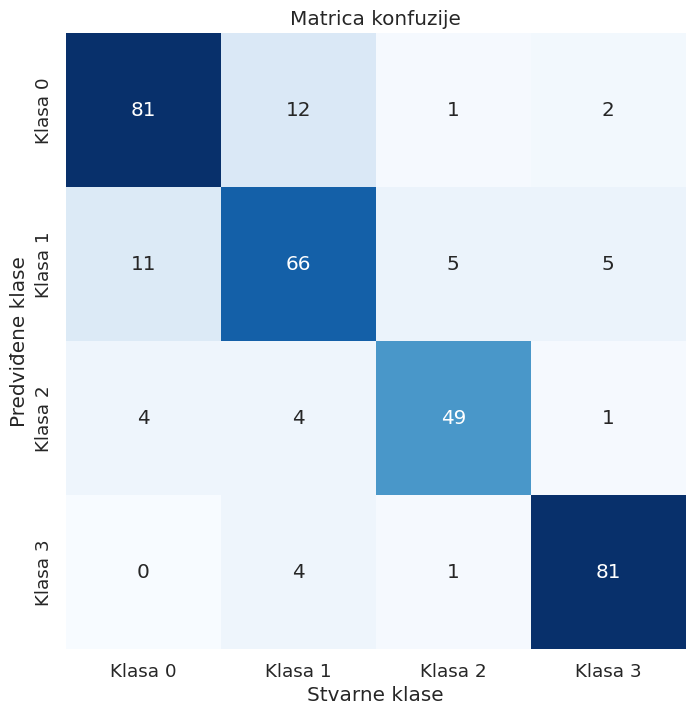

In [150]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Izračunajte matricu konfuzije
conf_mat = confusion_matrix(y_test_num, predicted_labels)

# Plotiranje matrice konfuzije
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Klasa 0", "Klasa 1", "Klasa 2", "Klasa 3"],
            yticklabels=["Klasa 0", "Klasa 1", "Klasa 2", "Klasa 3"])
plt.xlabel('Stvarne klase')
plt.ylabel('Predviđene klase')
plt.title('Matrica konfuzije')
plt.show()


##Promotrimo detaljnije dobivena predviđanja

In [151]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(labels[predicted_label],
                                100*np.max(predictions_array),
                                labels[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(4))
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

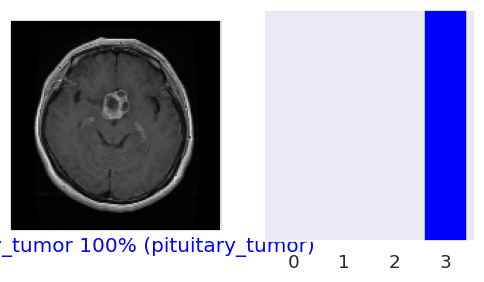

In [154]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test_num, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test_num)
plt.show()

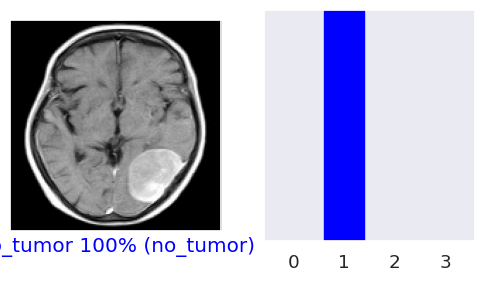

In [156]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test_num, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test_num)
plt.show()

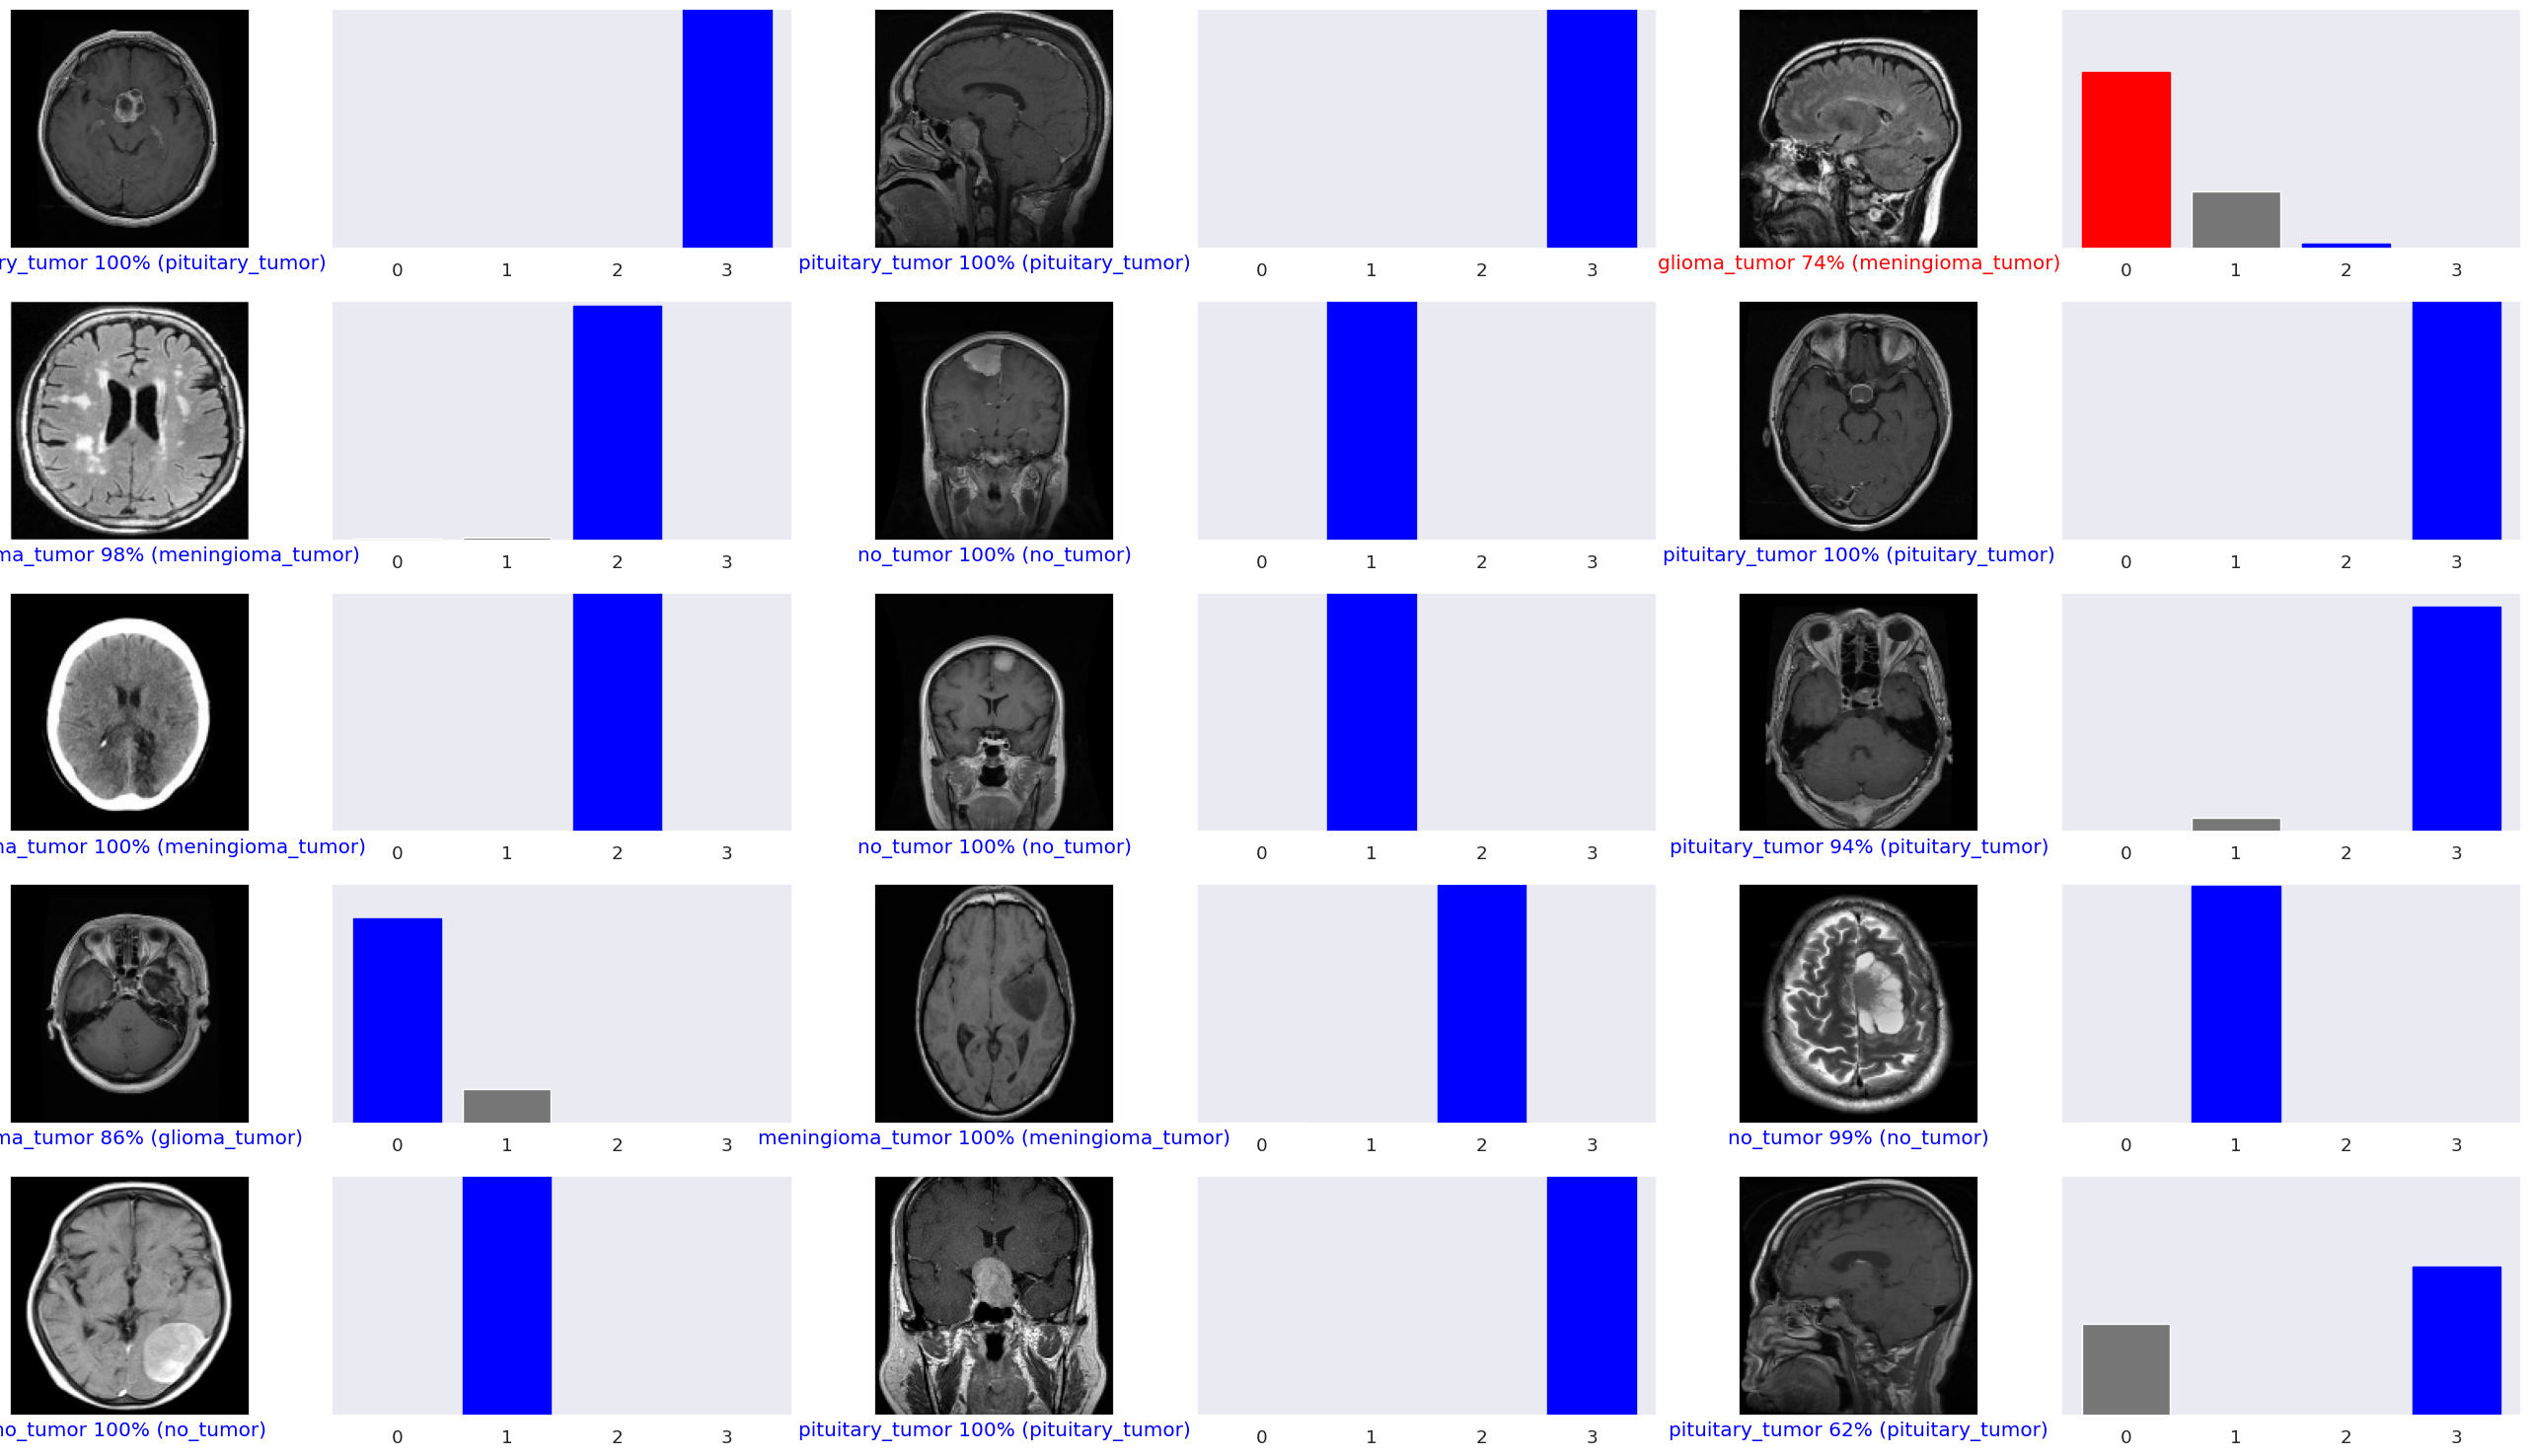

In [166]:
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(3*3*num_cols, 3*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], y_test_num, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test_num)
plt.tight_layout()
plt.show()


##Direktno predviđanje nad jednim podatkom

In [167]:
X_test.shape

(327, 150, 150, 3)

In [170]:
uzorak = X_test[1]
print(uzorak.shape)

(150, 150, 3)


In [171]:
# Add the image to a batch where it's the only member.
uzorak = (np.expand_dims(uzorak,0))

print(uzorak.shape)

(1, 150, 150, 3)


In [172]:
predictions_single = probability_model.predict(uzorak)

print(predictions_single)

1/1 [==============================] - 0s 483ms/step
[[0.17487776 0.17487788 0.17487782 0.4753665 ]]


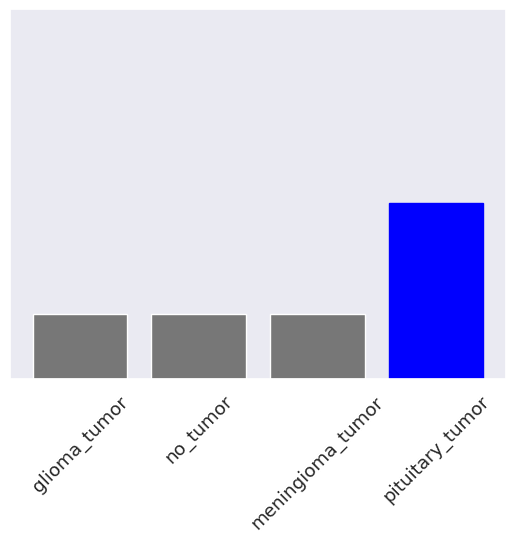

In [180]:
plot_value_array(1, predictions_single[0], y_test_num)
_ = plt.xticks(range(4), labels, rotation=45)
plt.show()

In [181]:
np.argmax(predictions_single[0])

3

##Pogledajmo primjere pogrešno razvrstanih slika

In [184]:
br_pogresnih = int((1-test_accuracy)*X_test.shape[0])
print('Pogrešno razvrstanih slika: {}/{}'.format(br_pogresnih, X_test.shape[0]))

Pogrešno razvrstanih slika: 50/327


In [185]:
import random

In [186]:
y_hat = model.predict(X_test)                                 # predviđanja modela na skupu za testiranje

11/11 [==============================] - 0s 10ms/step


In [187]:
pogresni = [(i, np.argmax(pred), labela, y_hat[i]) for i, (pred, labela) in enumerate(zip(y_hat, y_test_num)) if np.argmax(pred) != labela]

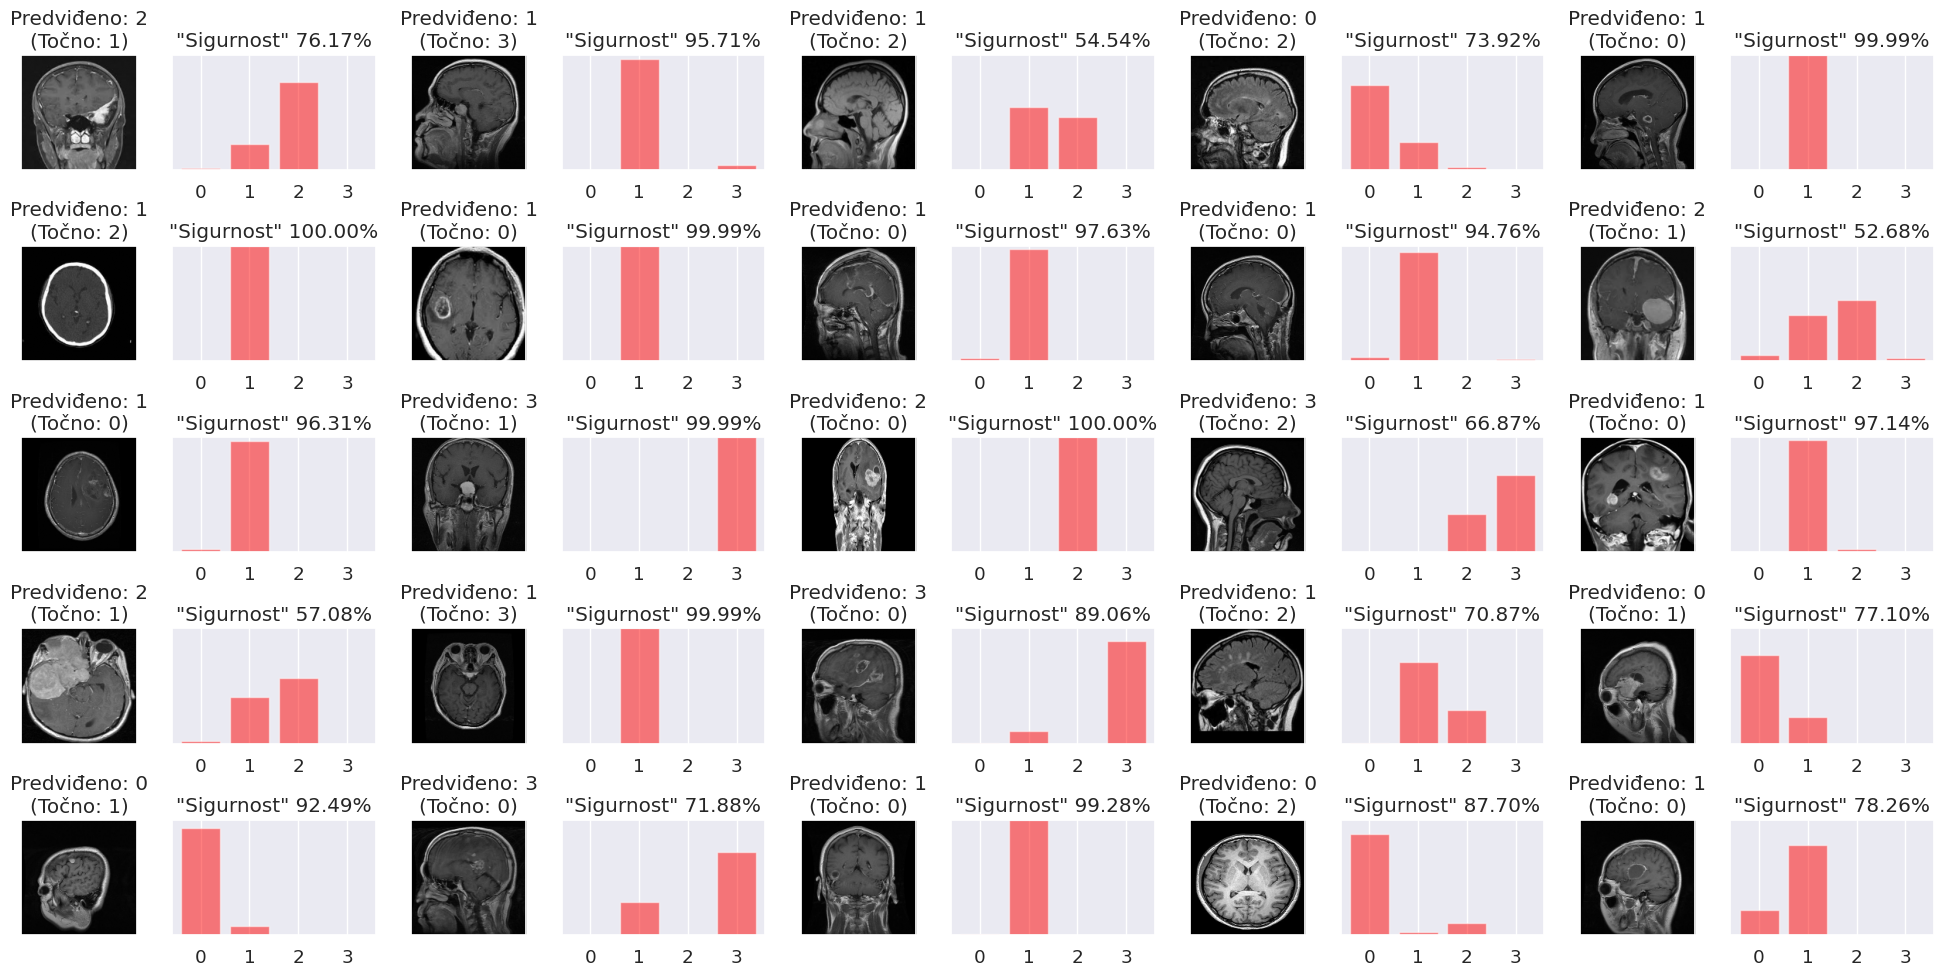

In [198]:
fig = plt.figure(figsize=(20, 10))
num_classes = 4
xs = np.arange(num_classes)

cnt = 0

for i, pred, tocno, pred_vjerojatnosti in random.sample(pogresni, 25):
    cnt += 1
    ax1 = fig.add_subplot(5, 10, cnt)
    plt.title("Predviđeno: {}\n(Točno: {})".format(pred, tocno))
    plt.imshow(X_test[i].reshape(150, 150, 3))  # Prilagodi veličinu slike prema potrebi
    plt.xticks([]), plt.yticks([])

    cnt += 1
    ax2 = fig.add_subplot(5, 10, cnt)
    sigurnost = pred_vjerojatnosti[pred] * 100
    plt.title("\"Sigurnost\" {:.2f}%".format(sigurnost))
    plt.bar(xs, pred_vjerojatnosti, color="red", alpha=0.5)
    plt.xticks(xs), plt.yticks([])
    plt.ylim([0, 1])
    plt.tight_layout()

plt.show()


In [199]:
np.unique(y_train_num)

array([0, 1, 2, 3])

In [200]:
np.unique(y_train)

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

##Nadogradnja Modela 1

U ovom primjeru dodan je još jedan konvolucijski sloj (Conv2D(256, (3, 3), activation='relu')) i povećan je broj jedinica u potpuno povezanom sloju (Dense(256, activation='relu')).


In [203]:
model_1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),  # Dodan dodatni konvolucijski sloj
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),  # Povećan broj jedinica u potpuno povezanom sloju
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model_1.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

# Treniranje modela
model_1.fit(X_train, y_train_onehot, epochs=10, validation_data=(X_test, y_test_onehot))

# Evaluacija modela na testnom skupu
test_loss, test_accuracy = model_1.evaluate(X_test, y_test_onehot, verbose=2)

print(f"\nTočnost na testnom skupu: {test_accuracy * 100:.2f}%")


Epoch 1/10
41/41 [==============================] - 4s 43ms/step - loss: 1.2186 - accuracy: 0.4606 - val_loss: 1.1052 - val_accuracy: 0.4557
Epoch 2/10
41/41 [==============================] - 1s 30ms/step - loss: 0.8674 - accuracy: 0.6358 - val_loss: 0.9776 - val_accuracy: 0.5994
Epoch 3/10
41/41 [==============================] - 1s 31ms/step - loss: 0.6715 - accuracy: 0.7238 - val_loss: 0.7195 - val_accuracy: 0.7584
Epoch 4/10
41/41 [==============================] - 1s 30ms/step - loss: 0.5687 - accuracy: 0.7682 - val_loss: 0.6902 - val_accuracy: 0.7309
Epoch 5/10
41/41 [==============================] - 1s 31ms/step - loss: 0.4119 - accuracy: 0.8523 - val_loss: 0.5796 - val_accuracy: 0.7890
Epoch 6/10
41/41 [==============================] - 1s 33ms/step - loss: 0.2954 - accuracy: 0.8914 - val_loss: 0.5305 - val_accuracy: 0.8287
Epoch 7/10
41/41 [==============================] - 1s 33ms/step - loss: 0.2020 - accuracy: 0.9288 - val_loss: 0.5223 - val_accuracy: 0.8318
Epoch 8/10
41

Manja točnost u odnosu na Model 1, nismo ništa dobili

##FC(Potpuno povezane neuronske mreže)

In [204]:
model_FC = tf.keras.models.Sequential()
model_FC.add(tf.keras.layers.Flatten(input_shape=(150, 150, 3)))
model_FC.add(tf.keras.layers.Dense(64, activation='relu'))
model_FC.add(tf.keras.layers.Dense(128, activation='relu'))
model_FC.add(tf.keras.layers.Dense(64, activation='relu'))
model_FC.add(tf.keras.layers.Dense(32, activation='relu'))
model_FC.add(tf.keras.layers.Dense(4, activation='softmax'))  # Promijeni na 4 ako imaš 4 klase

model_FC.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [205]:
model_FC.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_28 (Flatten)        (None, 67500)             0         
                                                                 
 dense_59 (Dense)            (None, 64)                4320064   
                                                                 
 dense_60 (Dense)            (None, 128)               8320      
                                                                 
 dense_61 (Dense)            (None, 64)                8256      
                                                                 
 dense_62 (Dense)            (None, 32)                2080      
                                                                 
 dense_63 (Dense)            (None, 4)                 132       
                                                                 
Total params: 4338852 (16.55 MB)
Trainable params: 43

sparse_categorical_crossentropy automatski radi konverziju numeričkih oznaka klasa u one-hot vektore

In [207]:
povijest_FC = model_FC.fit(X_train, y_train_num, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
17/17 [==============================] - 2s 52ms/step - loss: 2.0127 - accuracy: 0.3053 - val_loss: 1.2635 - val_accuracy: 0.4695
Epoch 2/10
17/17 [==============================] - 0s 22ms/step - loss: 1.2478 - accuracy: 0.4622 - val_loss: 1.2536 - val_accuracy: 0.4885
Epoch 3/10
17/17 [==============================] - 0s 23ms/step - loss: 1.1167 - accuracy: 0.5445 - val_loss: 1.1303 - val_accuracy: 0.4924
Epoch 4/10
17/17 [==============================] - 0s 22ms/step - loss: 0.9485 - accuracy: 0.6144 - val_loss: 1.1964 - val_accuracy: 0.4695
Epoch 5/10
17/17 [==============================] - 0s 26ms/step - loss: 0.9084 - accuracy: 0.6191 - val_loss: 1.0629 - val_accuracy: 0.5611
Epoch 6/10
17/17 [==============================] - 0s 24ms/step - loss: 0.8368 - accuracy: 0.6574 - val_loss: 1.1295 - val_accuracy: 0.5382
Epoch 7/10
17/17 [==============================] - 0s 17ms/step - loss: 0.7515 - accuracy: 0.6823 - val_loss: 0.9827 - val_accuracy: 0.5954
Epoch 8/10
17

In [212]:
_, test_acc = model_FC.evaluate(X_test, y_test_num, verbose=0)
print("Tocnost na skupu za testiranje: {:.2f}%".format(test_acc*100))

Tocnost na skupu za testiranje: 66.97%


In [213]:
def plot_history(hist_baseline, br_epoha, hist_FC=None):

    fig = plt.figure(figsize = (17,5))
    metrics = ["loss", "accuracy"]

    for i in range(len(metrics)):
        metric = metrics[i]
        plt.subplot(1, 2, i+1)
        plt.title(metric.capitalize())
        plt.xlabel("epoha")
        plt.ylabel(metric)
        plt.plot(range(1, br_epoha + 1), hist_baseline.history[metric],
                 label="train CNN", color="tab:blue")
        plt.plot(range(1, br_epoha + 1), hist_baseline.history["val_" + metric],
                 label="val CNN", color="tab:orange")

        if hist_FC:
            plt.plot(range(1, br_epoha + 1), hist_FC.history[metric],
                 label="train FC", color="tab:blue", linestyle='--', alpha=0.5)
            plt.plot(range(1, br_epoha + 1), hist_FC.history["val_" + metric],
                 label="val FC", color="tab:orange", linestyle='--', alpha=0.5)
        plt.legend()

10 je br epoha

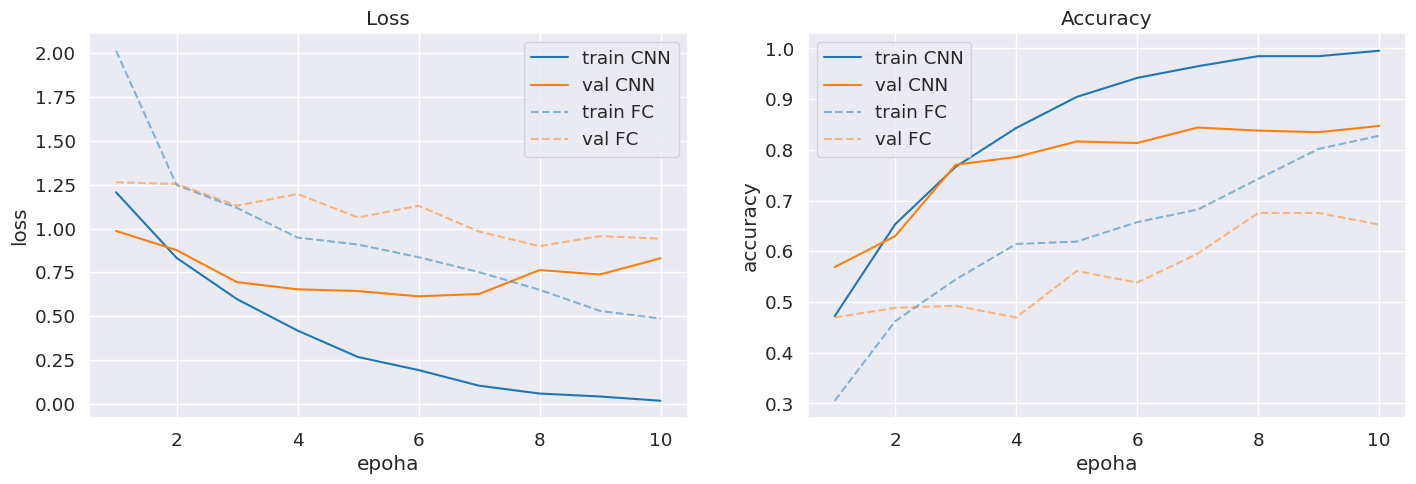

In [214]:
plot_history(povijest, 10, povijest_FC)

**ZAKLJUČAK USPOREDBA CNN I FN:** <br>Korištenje konvolucijskih neuronskih mreža (CNN) umjesto potpuno povezanih neuronskih mreža (FC) za obradu slika često dovodi do boljih rezultata iz nekoliko razloga:

Ekstrakcija značajki: CNN-ovi su dizajnirani da automatski izvlače značajke iz slika. Konvolucijski slojevi koriste lokalne filtere kako bi detektirali različite uzorke poput rubova, oblika i tekstura. Ovaj proces ekstrakcije značajki omogućava modelu da automatski nauči relevantne informacije iz slika.

Podrška za lokalnost i translacijsku invarijantnost: Konvolucijski slojevi dijele težine, što znači da se isti filteri primjenjuju na različite dijelove slike. To čini mrežu invarijantnom na translacije, što je važno za prepoznavanje objekata bez obzira na njihov položaj u slici.

Smanjenje dimenzionalnosti: Slojevi za agregaciju poput slojeva maksimalnog usklađivanja smanjuju prostornu dimenzionalnost, čime se smanjuje broj parametara u mreži i povećava računska efikasnost.

Bolja generalizacija: CNN-ovi obično imaju manje parametara od potpuno povezanih mreža, što može dovesti do bolje generalizacije na nove, neviđene podatke.

##KNN

##Usporedba korištenja različito kodiranih y

In [215]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


In [216]:
y_train_freq.shape

(1307,)

Sa y numeričkim

In [217]:
# Inicijalizacija k-NN klasifikatora
knn = KNeighborsClassifier(n_neighbors=5)

# Treniranje modela
knn.fit(X_train_izravnan, y_train_num)

# Predikcija na skupu za testiranje
y_pred = knn.predict(X_test_izravnan)

# Evaluacija modela
accuracy = metrics.accuracy_score(y_test_num, y_pred)
print("Točnost: {:.2f}%".format(accuracy * 100))

Točnost: 70.95%


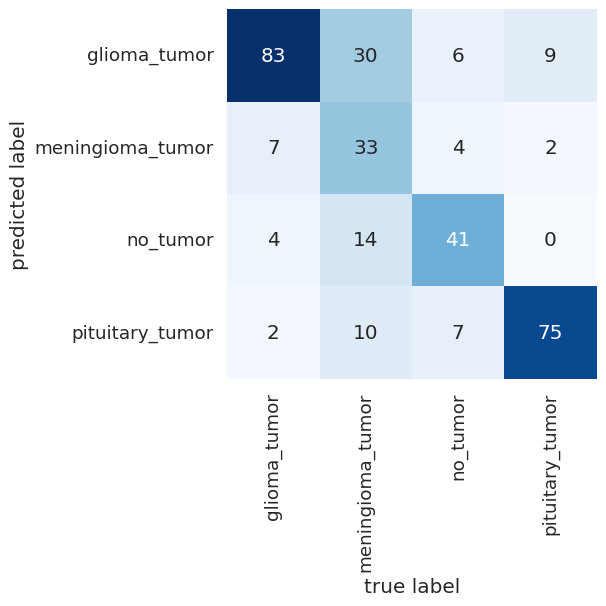

In [218]:
values = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

mat = metrics.confusion_matrix(y_test_num, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=values, yticklabels=values,
            cmap='Blues')

plt.xlabel('true label')
plt.ylabel('predicted label');

Sa y freq

In [219]:
# Inicijalizacija k-NN klasifikatora
knn = KNeighborsClassifier(n_neighbors=5)

# Treniranje modela
knn.fit(X_train_izravnan, y_train_freq)

# Predikcija na skupu za testiranje
y_pred = knn.predict(X_test_izravnan)

# Evaluacija modela
accuracy = metrics.accuracy_score(y_test_freq, y_pred)
print("Točnost: {:.2f}%".format(accuracy * 100))

Točnost: 68.20%


Sa y onehot

In [220]:
# Inicijalizacija k-NN klasifikatora
knn = KNeighborsClassifier(n_neighbors=5)

# Treniranje modela
knn.fit(X_train_izravnan, y_train_onehot)

# Predikcija na skupu za testiranje
y_pred = knn.predict(X_test_izravnan)

# Evaluacija modela
accuracy = metrics.accuracy_score(y_test_onehot, y_pred)
print("Točnost: {:.2f}%".format(accuracy * 100))

Točnost: 64.83%


največa točnost je kada smo koristili numerički kodiran y

##Najbolja vrijednost za k

In [221]:
param_grid = {'n_neighbors': range(1, 10)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_izravnan, y_train_num)
print("Najbolja vrijednost za k:", grid_search.best_params_)

Najbolja vrijednost za k: {'n_neighbors': 1}


In [222]:
# Inicijalizacija k-NN klasifikatora
knn = KNeighborsClassifier(n_neighbors=1)

# Treniranje modela
knn.fit(X_train_izravnan, y_train_num)

# Predikcija na skupu za testiranje
y_pred = knn.predict(X_test_izravnan)

# Evaluacija modela
accuracy = metrics.accuracy_score(y_test_num, y_pred)
print("Točnost: {:.2f}%".format(accuracy * 100))

Točnost: 80.12%


##Grupiranje podataka: kMeans

##Elbow metoda za najbolji k

Promatramo kako dodavanje nove grupe smanjuje sumu kvadrata udaljenosti (SSD) podataka od centara. Odabiremo  k  takav da se njegovim povećavanjem SSD neznatno smanji, a njegovim smanjivanje pogreška se znatno poveća.

In [223]:
from sklearn.cluster import KMeans

In [236]:
ssd = []
ks = range(1, 10)
for k in ks:
  k_model = KMeans(n_clusters=k, n_init='auto')
  k_model.fit(X_izravnan)
  ssd.append(k_model.inertia_)                        # inercija: suma kvadrata udaljenosti podataka do najbližeg centra (centra nakupine kojoj podatak pripada)

print(ssd)

[2912169.0410659304, 2530335.976503662, 2362942.6548381485, 2300397.568837679, 2246038.4752325993, 2207906.4002774237, 2175139.977639908, 2165358.2181771984, 2119197.701598553]


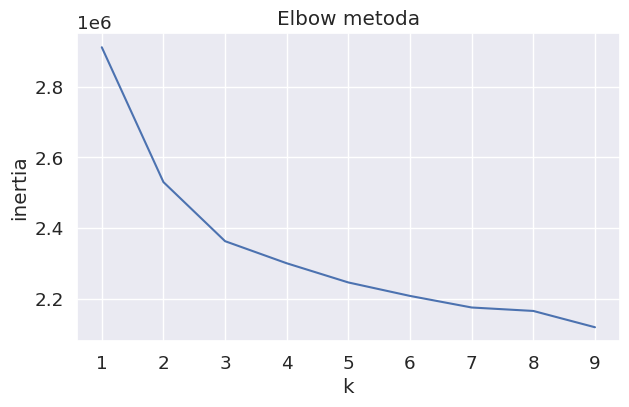

In [237]:
plt.figure(figsize=(7,4))
plt.plot(ks, ssd)
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Elbow metoda')
plt.show()

In [243]:
kmeans = KMeans(n_clusters=2, n_init='auto')
kmeans.fit(X_izravnan)

KMeans(n_clusters=2, n_init='auto')

In [244]:
centers = kmeans.cluster_centers_
print(f'CENTRI:\n{centers}')

CENTRI:
[[0.04120983 0.04120983 0.04120983 ... 0.04303347 0.04303347 0.04303347]
 [0.00572443 0.00572443 0.00572443 ... 0.00529855 0.00529855 0.00529855]]


In [245]:
y_kmeans = kmeans.predict(X_izravnan)                  # za svaku točku odredi "najbližu" grupu kojoj pripada
print(y_kmeans[:15])
## alterantivno za točke koje su korištene u fit
# kmeans.labels_


[1 1 1 0 1 1 1 1 0 1 1 1 1 0 1]


Prikaz grupiranja projekcije na prve 2 koordinate

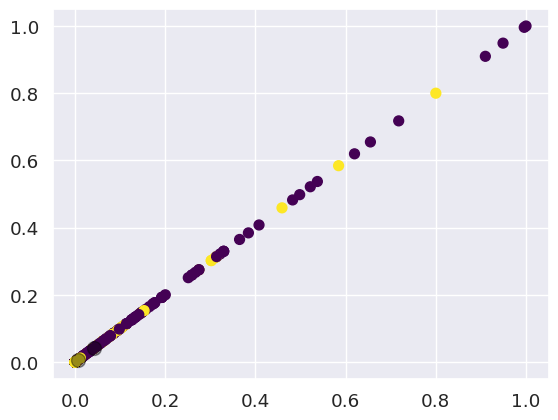

In [246]:
plt.scatter(X_izravnan[:, 0], X_izravnan[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.4);

Kvaliteta grupiranja(što bliže 1 to bolje)

In [247]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X_izravnan, y_kmeans)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.1786569661906042
